In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, auc,  roc_auc_score, classification_report, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [18]:
df = pd.read_csv('data_cleaned.csv', index_col= 'subject_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3748 entries, 10002760 to 19998591
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hospital_expire_flag         3748 non-null   int64  
 1   lactate                      3748 non-null   float64
 2   sodium                       3748 non-null   float64
 3   potassium                    3748 non-null   float64
 4   bun_avg                      3748 non-null   float64
 5   wbc                          3748 non-null   float64
 6   hemoglobin                   3748 non-null   float64
 7   ph                           3748 non-null   float64
 8   systolic_blood_pressure      3748 non-null   float64
 9   diastolic_blood_pressure     3748 non-null   float64
 10  respiratory_rate             3748 non-null   float64
 11  spo2                         3748 non-null   float64
 12  arterial_o2_pressure         3748 non-null   float64
 13  temperature 

In [19]:
X = df.drop(columns=['hospital_expire_flag'])
y = df['hospital_expire_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2998, 35), (750, 35), (2998,), (750,))

In [20]:
def print_model_results(model_name, classification_report, confusion_matrix, roc_auc):
    print(f"Model: {model_name}\n")
    print("Classification Report:")
    print(classification_report)
    print("\nConfusion Matrix:")
    print(f"TN: {confusion_matrix[0][0]}, FP: {confusion_matrix[0][1]}")
    print(f"FN: {confusion_matrix[1][0]}, TP: {confusion_matrix[1][1]}")
    print(f"\nROC AUC: {roc_auc:.4f}\n")

# random forest

In [27]:
random_forest_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
random_forest_model.fit(X_train, y_train)
rf_y_pred = random_forest_model.predict(X_test)
rf_y_pred_proba = random_forest_model.predict_proba(X_test)[:, 1]
random_forest_results = {
    "Model": "Random Forest",
    "Classification Report": classification_report(y_test, rf_y_pred),
    "Confusion Matrix": confusion_matrix(y_test, rf_y_pred),
    "ROC AUC": roc_auc_score(y_test, rf_y_pred_proba)
}
print_model_results(
    model_name=random_forest_results["Model"],
    classification_report=classification_report(y_test, rf_y_pred, target_names=["Survived", "Expired"]),
    confusion_matrix=random_forest_results["Confusion Matrix"],
    roc_auc=random_forest_results["ROC AUC"]
)

Model: Random Forest

Classification Report:
              precision    recall  f1-score   support

    Survived       0.88      0.99      0.94       649
     Expired       0.80      0.16      0.26       101

    accuracy                           0.88       750
   macro avg       0.84      0.58      0.60       750
weighted avg       0.87      0.88      0.85       750


Confusion Matrix:
TN: 645, FP: 4
FN: 85, TP: 16

ROC AUC: 0.8650



In [28]:
random_forest_results = {
    "Model": "Random Forest",
    "Classification Report": classification_report(y_test, rf_y_pred),
    "Confusion Matrix": confusion_matrix(y_test, rf_y_pred),
    "ROC AUC": roc_auc_score(y_test, rf_y_pred_proba)
}

In [7]:
print_model_results(
    model_name=random_forest_results["Model"],
    classification_report=classification_report(y_test, rf_y_pred, target_names=["Survived", "Expired"]),
    confusion_matrix=random_forest_results["Confusion Matrix"],
    roc_auc=random_forest_results["ROC AUC"]
)

Model: Random Forest

Classification Report:
              precision    recall  f1-score   support

    Survived       0.88      0.99      0.94       649
     Expired       0.80      0.16      0.26       101

    accuracy                           0.88       750
   macro avg       0.84      0.58      0.60       750
weighted avg       0.87      0.88      0.85       750


Confusion Matrix:
TN: 645, FP: 4
FN: 85, TP: 16

ROC AUC: 0.8650



In [29]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

# Function to calculate ROC AUC score for bootstrapping
def bootstrap_roc_auc(model, X_test, y_test, n_iterations=1000, random_state=None):
    # Store the ROC AUC scores from each iteration
    roc_auc_scores = []
    
    # Perform bootstrapping
    for _ in range(n_iterations):
        # Generate a bootstrap sample from the test data
        X_resampled, y_resampled = resample(X_test, y_test, random_state=random_state)
        
        # Predict probabilities for the bootstrap sample
        y_resampled_proba = model.predict_proba(X_resampled)[:, 1]
        
        # Calculate ROC AUC score and append it to the list
        roc_auc_scores.append(roc_auc_score(y_resampled, y_resampled_proba))
    
    # Calculate the mean ROC AUC
    mean_roc_auc = np.mean(roc_auc_scores)
    
    # Calculate the lower and upper percentiles for the confidence interval
    lower = np.percentile(roc_auc_scores, 2.5)
    upper = np.percentile(roc_auc_scores, 97.5)
    
    return mean_roc_auc, lower, upper

# Calculate the 95% confidence interval for the ROC AUC score
mean_roc_auc, lower, upper = bootstrap_roc_auc(random_forest_model, X_test, y_test)

# Print the results
print(f"Mean ROC AUC: {mean_roc_auc:.4f}")
print(f"95% Confidence Interval: ({lower:.4f}, {upper:.4f})")


Mean ROC AUC: 0.8651
95% Confidence Interval: (0.8275, 0.9004)


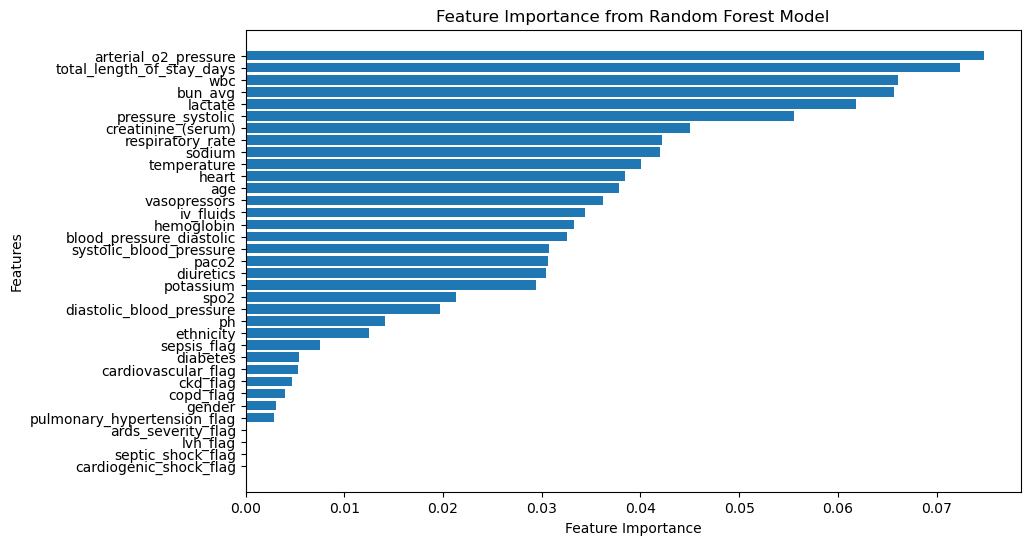

In [9]:
feature_importances = random_forest_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis() 
plt.show()

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

# Fit the model with Grid Search
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
rf_y_pred = best_rf_model.predict(X_test)
rf_y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Calculate the best ROC AUC score
roc_auc = roc_auc_score(y_test, rf_y_pred_proba)

# Collect the results
random_forest_results = {
    "Model": "Random Forest (Tuned)",
    "Best Parameters": grid_search.best_params_,
    "Classification Report": classification_report(y_test, rf_y_pred, target_names=["Survived", "Expired"]),
    "Confusion Matrix": confusion_matrix(y_test, rf_y_pred),
    "ROC AUC": roc_auc
}

# Print the results
print_model_results(
    model_name=random_forest_results["Model"],
    classification_report=random_forest_results["Classification Report"],
    confusion_matrix=random_forest_results["Confusion Matrix"],
    roc_auc=random_forest_results["ROC AUC"]
)

# Print the best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s



[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
372 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.11/site-

Model: Random Forest (Tuned)

Classification Report:
              precision    recall  f1-score   support

    Survived       0.89      0.99      0.94       649
     Expired       0.84      0.21      0.33       101

    accuracy                           0.89       750
   macro avg       0.86      0.60      0.64       750
weighted avg       0.88      0.89      0.86       750


Confusion Matrix:
TN: 645, FP: 4
FN: 80, TP: 21

ROC AUC: 0.8813

Best Hyperparameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [13]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

# Function to calculate ROC AUC score for bootstrapping
def bootstrap_roc_auc(model, X_test, y_test, n_iterations=1000, random_state=None):
    # Store the ROC AUC scores from each iteration
    roc_auc_scores = []
    
    # Perform bootstrapping
    for _ in range(n_iterations):
        # Generate a bootstrap sample from the test data
        X_resampled, y_resampled = resample(X_test, y_test, random_state=random_state)
        
        # Predict probabilities for the bootstrap sample
        y_resampled_proba = model.predict_proba(X_resampled)[:, 1]
        
        # Calculate ROC AUC score and append it to the list
        roc_auc_scores.append(roc_auc_score(y_resampled, y_resampled_proba))
    
    # Calculate the mean ROC AUC
    mean_roc_auc = np.mean(roc_auc_scores)
    
    # Calculate the lower and upper percentiles for the confidence interval
    lower = np.percentile(roc_auc_scores, 2.5)
    upper = np.percentile(roc_auc_scores, 97.5)
    
    return mean_roc_auc, lower, upper

# Calculate the 95% confidence interval for the ROC AUC score of the tuned Random Forest model
mean_roc_auc, lower, upper = bootstrap_roc_auc(best_rf_model, X_test, y_test)

# Print the results
print(f"Mean ROC AUC: {mean_roc_auc:.4f}")
print(f"95% Confidence Interval: ({lower:.4f}, {upper:.4f})")


Mean ROC AUC: 0.8874
95% Confidence Interval: (0.8523, 0.9188)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Define the Random Forest model with balanced class weights
random_forest_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define a wider hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
}

# Initialize RandomizedSearchCV for better efficiency
randomized_search = RandomizedSearchCV(
    estimator=random_forest_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter combinations to try
    cv=5,  # Cross-validation folds
    scoring='roc_auc',  # Optimize ROC AUC
    n_jobs=-1,  # Use all processors
    random_state=42,
    verbose=2
)

# Fit the RandomizedSearchCV
randomized_search.fit(X_train, y_train)

# Get the best model from the search
best_rf_model = randomized_search.best_estimator_

# Predictions and probabilities
rf_y_pred = best_rf_model.predict(X_test)
rf_y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
roc_auc = roc_auc_score(y_test, rf_y_pred_proba)
print("ROC AUC Score:", roc_auc)
print("Classification Report:\n", classification_report(y_test, rf_y_pred, target_names=["Survived", "Expired"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_y_pred))

# --- Ensemble Learning Example ---
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier

# Define a Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Define a Voting Classifier combining Random Forest and Gradient Boosting
ensemble_model = VotingClassifier(estimators=[
    ('rf', best_rf_model), 
    ('gb', gb_model)
], voting='soft')

# Fit the ensemble model
ensemble_model.fit(X_train, y_train)

# Predictions and probabilities with the ensemble model
ensemble_y_pred = ensemble_model.predict(X_test)
ensemble_y_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]

# Evaluate the ensemble model
ensemble_roc_auc = roc_auc_score(y_test, ensemble_y_pred_proba)
print("Ensemble ROC AUC Score:", ensemble_roc_auc)
print("Ensemble Classification Report:\n", classification_report(y_test, ensemble_y_pred, target_names=["Survived", "Expired"]))
print("Ensemble Confusion Matrix:\n", confusion_matrix(y_test, ensemble_y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=15, n_estimators=200; total time=   1.8s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=15, n_estimators=200; total time=   1.8s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=15, n_estimators

In [12]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

# Function to calculate ROC AUC score for bootstrapping
def bootstrap_roc_auc(model, X_test, y_test, n_iterations=1000, random_state=None):
    # Store the ROC AUC scores from each iteration
    roc_auc_scores = []
    
    # Perform bootstrapping
    for _ in range(n_iterations):
        # Generate a bootstrap sample from the test data
        X_resampled, y_resampled = resample(X_test, y_test, random_state=random_state)
        
        # Predict probabilities for the bootstrap sample
        y_resampled_proba = model.predict_proba(X_resampled)[:, 1]
        
        # Calculate ROC AUC score and append it to the list
        roc_auc_scores.append(roc_auc_score(y_resampled, y_resampled_proba))
    
    # Calculate the mean ROC AUC
    mean_roc_auc = np.mean(roc_auc_scores)
    
    # Calculate the lower and upper percentiles for the confidence interval
    lower = np.percentile(roc_auc_scores, 2.5)
    upper = np.percentile(roc_auc_scores, 97.5)
    
    return mean_roc_auc, lower, upper

# Calculate the 95% confidence interval for the ROC AUC score of the tuned Random Forest model
mean_roc_auc, lower, upper = bootstrap_roc_auc(ensemble_model, X_test, y_test)

# Print the results
print(f"Mean ROC AUC: {mean_roc_auc:.4f}")
print(f"95% Confidence Interval: ({lower:.4f}, {upper:.4f})")


Mean ROC AUC: 0.8864
95% Confidence Interval: (0.8504, 0.9151)


Feature Selection

In [13]:
columns_to_drop = [
    "ards_severity_flag",
    "lvh_flag",
    "septic_shock_flag",
    "cardiogenic_shock_flag"
]

df2 = df.drop(columns=columns_to_drop, axis=1)

In [14]:
X = df2.drop(columns=['hospital_expire_flag'])
y = df2['hospital_expire_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2998, 31), (750, 31), (2998,), (750,))

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

# Fit the model with Grid Search
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
rf_y_pred = best_rf_model.predict(X_test)
rf_y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Calculate the best ROC AUC score
roc_auc = roc_auc_score(y_test, rf_y_pred_proba)

# Collect the results
random_forest_results = {
    "Model": "Random Forest (Tuned)",
    "Best Parameters": grid_search.best_params_,
    "Classification Report": classification_report(y_test, rf_y_pred, target_names=["Survived", "Expired"]),
    "Confusion Matrix": confusion_matrix(y_test, rf_y_pred),
    "ROC AUC": roc_auc
}

# Print the results
print_model_results(
    model_name=random_forest_results["Model"],
    classification_report=random_forest_results["Classification Report"],
    confusion_matrix=random_forest_results["Confusion Matrix"],
    roc_auc=random_forest_results["ROC AUC"]
)

# Print the best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
395 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.11/site-

Model: Random Forest (Tuned)

Classification Report:
              precision    recall  f1-score   support

    Survived       0.91      0.98      0.94       649
     Expired       0.71      0.37      0.48       101

    accuracy                           0.89       750
   macro avg       0.81      0.67      0.71       750
weighted avg       0.88      0.89      0.88       750


Confusion Matrix:
TN: 634, FP: 15
FN: 64, TP: 37

ROC AUC: 0.8809

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


#### SHAP

In [ ]:
import shap
import matplotlib.pyplot as plt

# Create the SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)


In [28]:
shap_values

array([[[-0.03014969,  0.03014969],
        [ 0.0211954 , -0.0211954 ],
        [ 0.00865897, -0.00865897],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.05213596, -0.05213596]],

       [[ 0.02590056, -0.02590056],
        [ 0.01717035, -0.01717035],
        [ 0.01092327, -0.01092327],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.03866925, -0.03866925]],

       [[ 0.04721608, -0.04721608],
        [ 0.02591294, -0.02591294],
        [ 0.0045829 , -0.0045829 ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.03809428, -0.03809428]],

       ...,

       [[ 0.01709461, -0.01709461],
        [ 0.02129973, -0.02129973],
        [ 0.00395358, -0.00395358],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.02690293, -0.02690293]],

       [[ 0.0288453 , -0.0288453 ],
        [-0.02598873,  0.02

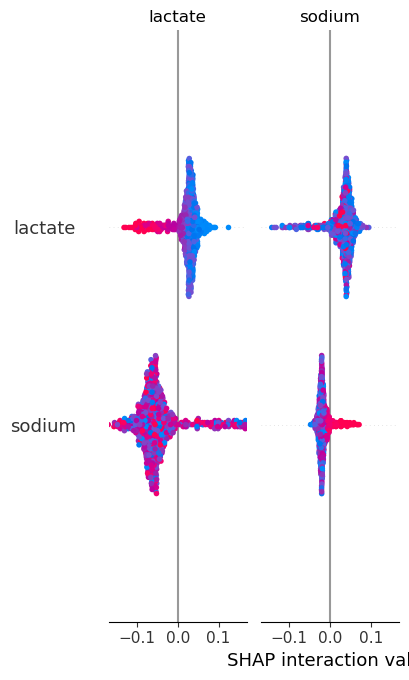

In [30]:
# Generate a SHAP summary plot
shap.summary_plot(shap_values, X_test)

## Linear Regression

In [11]:
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)
lr_y_pred_proba = linear_reg_model.predict(X_test)
lr_y_pred = (lr_y_pred_proba >= 0.5).astype(int) 

In [12]:
linear_reg_results = {
    "Model": "Linear Regression",
    "Classification Report、": 
    classification_report(y_test, lr_y_pred),
    "Confusion Matrix": confusion_matrix(y_test, lr_y_pred),
    "ROC AUC": roc_auc_score(y_test, lr_y_pred_proba)
}


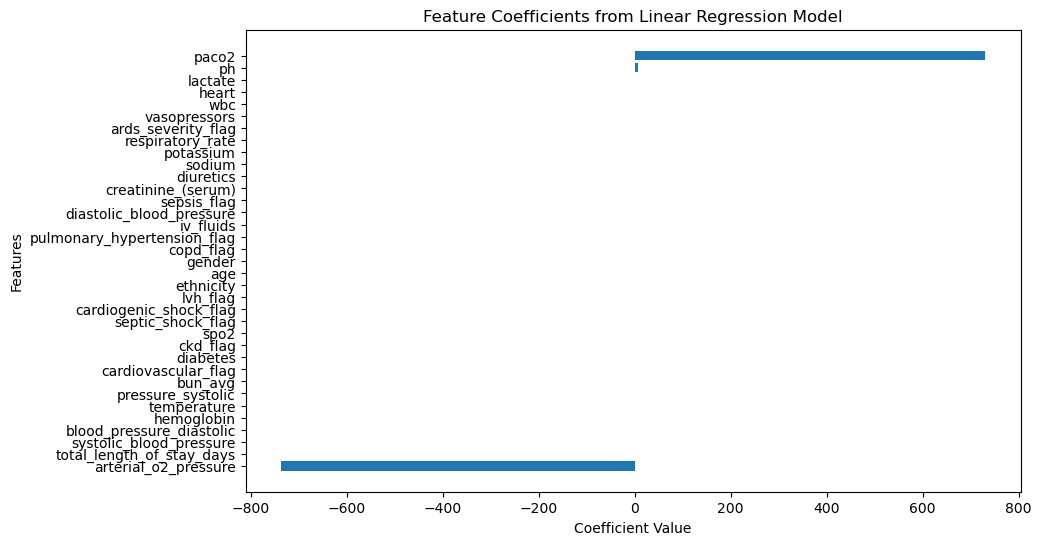

In [13]:
linear_coefficients = linear_reg_model.coef_
linear_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': linear_coefficients
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(linear_feature_importance_df['Feature'], linear_feature_importance_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Coefficients from Linear Regression Model')
plt.gca().invert_yaxis()  
plt.show()

In [14]:
print_model_results(
    model_name=linear_reg_results["Model"],
    classification_report=classification_report(y_test, lr_y_pred, target_names=["Survived", "Expired"]),
    confusion_matrix=linear_reg_results["Confusion Matrix"],
    roc_auc=linear_reg_results["ROC AUC"]
)

Model: Linear Regression

Classification Report:
              precision    recall  f1-score   support

    Survived       0.87      0.99      0.93       649
     Expired       0.56      0.05      0.09       101

    accuracy                           0.87       750
   macro avg       0.71      0.52      0.51       750
weighted avg       0.83      0.87      0.82       750


Confusion Matrix:
TN: 645, FP: 4
FN: 96, TP: 5

ROC AUC: 0.8248



## NN

In [16]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba >= 0.5).astype(int)

test_loss, test_accuracy, y_pred_proba[:5], y_pred[:5]

Epoch 1/30


C:\Users\a9191\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7356 - loss: 1.7916 - val_accuracy: 0.8667 - val_loss: 0.6519
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.7976 - loss: 0.7311 - val_accuracy: 0.8667 - val_loss: 0.4355
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.8048 - loss: 0.5457 - val_accuracy: 0.8667 - val_loss: 0.4464
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.8276 - loss: 0.4831 - val_accuracy: 0.8667 - val_loss: 0.4236
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8431 - loss: 0.4630 - val_accuracy: 0.8667 - val_loss: 0.4322
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.8635 - loss: 0.4448 - val_accuracy: 0.8667 - val_loss: 0.4294
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.8578 - loss: 0.4530 - val_accuracy: 0.8667 - val_loss: 0.4294
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.8620 - loss: 0.4449 - val_accuracy: 0.8667 - val_loss

(0.3834170401096344,
 0.8653333187103271,
 array([0.2105612 , 0.22057687, 0.1295612 , 0.12902951, 0.22782186],
       dtype=float32),
 array([0, 0, 0, 0, 0]))

In [17]:
# Compute metrics
nn_conf_matrix = confusion_matrix(y_test, y_pred)
nn_class_report = classification_report(y_test, y_pred, target_names=["Survived", "Expired"])
nn_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Store the results in a dictionary
nn_results = {
    "Model": "Neural Network",
    "Classification Report": nn_class_report,
    "Confusion Matrix": nn_conf_matrix,
    "ROC AUC": nn_roc_auc
}

# Print the NN model results
print_model_results(
    model_name=nn_results["Model"],
    classification_report=nn_results["Classification Report"],
    confusion_matrix=nn_results["Confusion Matrix"],
    roc_auc=nn_results["ROC AUC"]
)

Model: Neural Network

Classification Report:
              precision    recall  f1-score   support

    Survived       0.87      1.00      0.93       649
     Expired       0.00      0.00      0.00       101

    accuracy                           0.87       750
   macro avg       0.43      0.50      0.46       750
weighted avg       0.75      0.87      0.80       750


Confusion Matrix:
TN: 649, FP: 0
FN: 101, TP: 0

ROC AUC: 0.6637



C:\Users\a9191\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\a9191\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\a9191\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The neural network is overfitting and ends up predicting all outputs as 0.

## Logistic Regression

In [41]:
logistic_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predict and calculate probabilities
logistic_y_pred = logistic_model.predict(X_test)
logistic_y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]


In [47]:
logistic_results = {
    "Model": "Logistic Regression",
    "Classification Report": classification_report(y_test, logistic_y_pred, target_names=["Survived", "Expired"]),
    "Confusion Matrix": confusion_matrix(y_test, logistic_y_pred),
    "ROC AUC": roc_auc_score(y_test, logistic_y_pred_proba)
}

print_model_results(
    model_name=logistic_results["Model"],
    classification_report=classification_report(y_test, logistic_y_pred, target_names=["Survived", "Expired"]),
    confusion_matrix=logistic_results["Confusion Matrix"],
    roc_auc=logistic_results["ROC AUC"]
)

Model: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

    Survived       0.95      0.75      0.84       649
     Expired       0.31      0.73      0.44       101

    accuracy                           0.75       750
   macro avg       0.63      0.74      0.64       750
weighted avg       0.86      0.75      0.78       750


Confusion Matrix:
TN: 486, FP: 163
FN: 27, TP: 74

ROC AUC: 0.7963



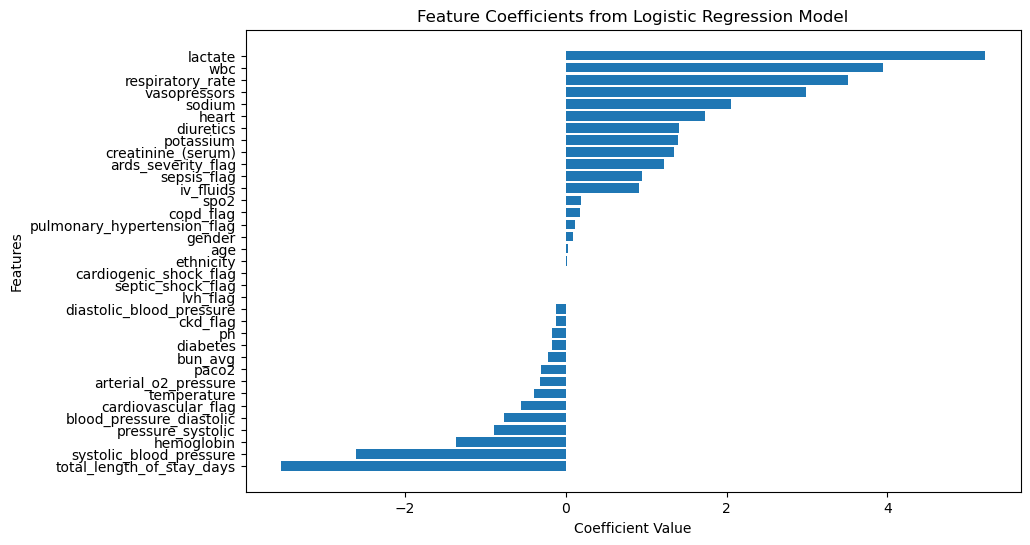

In [49]:
logistic_coefficients = logistic_model.coef_[0]

feature_coefficients_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logistic_coefficients
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_coefficients_df['Feature'], feature_coefficients_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Coefficients from Logistic Regression Model')
plt.gca().invert_yaxis() 
plt.show()

## Gradient Boost

In [55]:
gradient_boost_model = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
gradient_boost_model.fit(X_train, y_train)

gb_y_pred = gradient_boost_model.predict(X_test)
gb_y_pred_proba = gradient_boost_model.predict_proba(X_test)[:, 1]

In [59]:
gradient_boost_results = {
    "Model": "Gradient Boosting",
    "Classification Report": classification_report(y_test, gb_y_pred, target_names=["Survived", "Expired"]),
    "Confusion Matrix": confusion_matrix(y_test, gb_y_pred),
    "ROC AUC": roc_auc_score(y_test, gb_y_pred_proba)
}
print_model_results(
    model_name=gradient_boost_results["Model"],
    classification_report=classification_report(y_test, gb_y_pred, target_names=["Survived", "Expired"]),
    confusion_matrix=gradient_boost_results["Confusion Matrix"],
    roc_auc=gradient_boost_results["ROC AUC"]
)

Model: Gradient Boosting

Classification Report:
              precision    recall  f1-score   support

    Survived       0.91      0.98      0.94       649
     Expired       0.72      0.38      0.49       101

    accuracy                           0.90       750
   macro avg       0.81      0.68      0.72       750
weighted avg       0.88      0.90      0.88       750


Confusion Matrix:
TN: 634, FP: 15
FN: 63, TP: 38

ROC AUC: 0.8757



## XGboost

In [71]:
xgboost_model = XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3, eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

xgb_y_pred = xgboost_model.predict(X_test)
xgb_y_pred_proba = xgboost_model.predict_proba(X_test)[:, 1]

In [73]:
xgboost_results = {
    "Model": "XGBoost",
    "Classification Report": classification_report(y_test, xgb_y_pred, target_names=["Survived", "Expired"]),
    "Confusion Matrix": confusion_matrix(y_test, xgb_y_pred),
    "ROC AUC": roc_auc_score(y_test, xgb_y_pred_proba)
}

In [75]:
print_model_results(
    model_name=xgboost_results["Model"],
    classification_report=classification_report(y_test, xgb_y_pred, target_names=["Survived", "Expired"]),
    confusion_matrix=xgboost_results["Confusion Matrix"],
    roc_auc=xgboost_results["ROC AUC"]
)

Model: XGBoost

Classification Report:
              precision    recall  f1-score   support

    Survived       0.91      0.98      0.95       649
     Expired       0.78      0.38      0.51       101

    accuracy                           0.90       750
   macro avg       0.84      0.68      0.73       750
weighted avg       0.89      0.90      0.89       750


Confusion Matrix:
TN: 638, FP: 11
FN: 63, TP: 38

ROC AUC: 0.8787



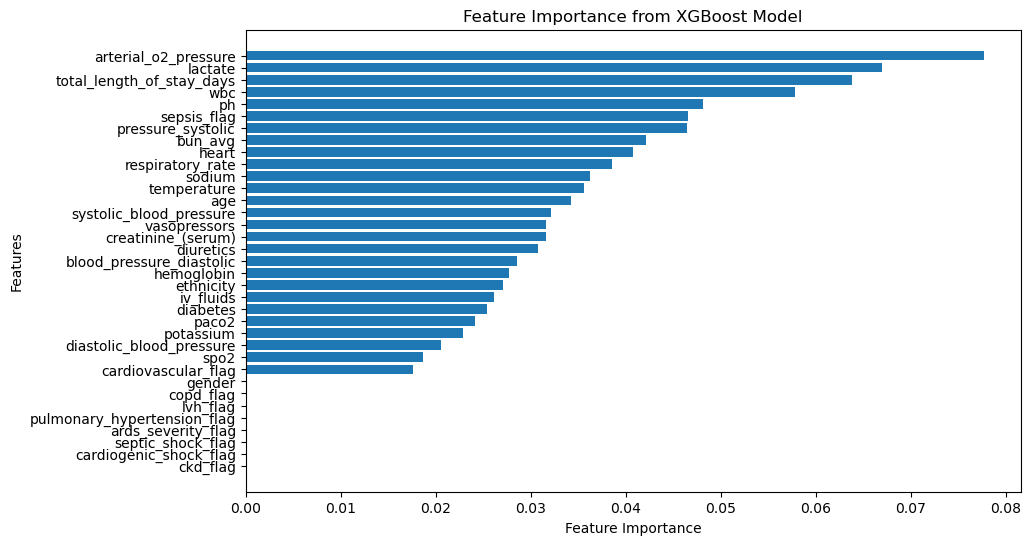

In [79]:
xgb_feature_importances = xgboost_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from XGBoost Model')
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
plt.show()

## Naive Bayes

In [90]:
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)

# Predict and calculate probabilities
nb_y_pred = naive_bayes_model.predict(X_test)
nb_y_pred_proba = naive_bayes_model.predict_proba(X_test)[:, 1]


In [92]:
naive_bayes_results = {
    "Model": "Naive Bayes",
    "Classification Report": classification_report(y_test, nb_y_pred, target_names=["Survived", "Expired"]),
    "Confusion Matrix": confusion_matrix(y_test, nb_y_pred),
    "ROC AUC": roc_auc_score(y_test, nb_y_pred_proba)
}

print_model_results(
    model_name=naive_bayes_results["Model"],
    classification_report=classification_report(y_test, nb_y_pred, target_names=["Survived", "Expired"]),
    confusion_matrix=naive_bayes_results["Confusion Matrix"],
    roc_auc=naive_bayes_results["ROC AUC"]
)

Model: Naive Bayes

Classification Report:
              precision    recall  f1-score   support

    Survived       0.96      0.03      0.07       649
     Expired       0.14      0.99      0.24       101

    accuracy                           0.16       750
   macro avg       0.55      0.51      0.15       750
weighted avg       0.85      0.16      0.09       750


Confusion Matrix:
TN: 22, FP: 627
FN: 1, TP: 100

ROC AUC: 0.7361



## KNN

In [103]:
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  # Default: 5 neighbors, Euclidean distance
knn_model.fit(X_train, y_train)

knn_y_pred = knn_model.predict(X_test)
knn_y_pred_proba = knn_model.predict_proba(X_test)[:, 1]


In [105]:
knn_results = {
    "Model": "K-Nearest Neighbors",
    "Classification Report": classification_report(y_test, knn_y_pred, target_names=["Survived", "Expired"]),
    "Confusion Matrix": confusion_matrix(y_test, knn_y_pred),
    "ROC AUC": roc_auc_score(y_test, knn_y_pred_proba)
}
print_model_results(
    model_name=knn_results["Model"],
    classification_report=classification_report(y_test, knn_y_pred, target_names=["Survived", "Expired"]),
    confusion_matrix=knn_results["Confusion Matrix"],
    roc_auc=knn_results["ROC AUC"]
)

Model: K-Nearest Neighbors

Classification Report:
              precision    recall  f1-score   support

    Survived       0.87      0.98      0.92       649
     Expired       0.27      0.04      0.07       101

    accuracy                           0.86       750
   macro avg       0.57      0.51      0.50       750
weighted avg       0.79      0.86      0.81       750


Confusion Matrix:
TN: 638, FP: 11
FN: 97, TP: 4

ROC AUC: 0.5687

